<a href="https://colab.research.google.com/github/emreaniloguz/GANs-Colab/blob/main/Syntonym-Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Syntonym/GAN/syntonymcase
%ls


/content/drive/MyDrive/Syntonym/GAN/syntonymcase
aligned_images/   shape_predictor_5_face_landmarks.dat
dnnlib/           shape_predictor_5_face_landmarks.dat.bz2
legacy.py         shape_predictor_5_face_landmarks.dat.bz2.1
out/              shape_predictor_5_face_landmarks.dat.bz2.2
projection_data/  shape_predictor_5_face_landmarks.dat.bz2.5
projection_out/   stylegan2-ada-pytorch/
__pycache__/      style_out/
result.png        torch_utils/


In [ ]:
import sys
import os
from google.colab import files
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt
import cv2
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
#
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm
from time import perf_counter
import legacy
import copy
import torch.nn.functional as F
import glob



In [ ]:
STEPS = 3

In [ ]:
#Our dataset
network = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

#For the face align
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

#Stylegan2 clone
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import dnnlib


--2022-05-11 11:48:18--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2.2’

shape_predictor_5_f 100%[===================>]   5.44M  1.86MB/s    in 2.9s    

2022-05-11 11:48:22 (1.86 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2.2’ saved [5706710/5706710]

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [ ]:
def return_image_files(path):
  f_name_list = []
  for filename in glob.glob(path):
    f_name_list.append(filename)
  
  return f_name_list




    


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img_path):
  img= cv2.imread(img_path)
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  a=img_path.split("/")[1].split(".")[0].split("e")[1]

  cv2.imwrite(f"aligned_images/cropped_img{a}.png",img3[crop0:crop0+1024,crop1:crop1+1024])
  

In [ ]:

def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    return w_out.repeat([1, G.mapping.num_ws, 1])

In [ ]:
def plot_images(images, num_blocks,titles=None):
    """Plot images in a grid of subplots."""
    fig = plt.figure(figsize=(5, num_blocks),dpi=1024)
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    #plt.show()
    plt.savefig("result.png")
    print("Done")
    
def splitpath(path):
    
    print(path)
    if path != "out/proj.png":
        return int(path.split("step")[1].split(".")[0])

def return_images(path,num_blocks):
    """Return a list of images from a path."""
    images = []
    f_name_list = []
    for filename in glob.glob(path):
        
        f_name_list.append(filename)

        
    f_name_list.sort(key=splitpath)
    for filename in f_name_list:
        images.append(cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB))
    
    

    plot_images(images,num_blocks)


In [ ]:
from re import I
def run_projection(
    network_pkl: str,
    target_fname: str,
    outdir: str,
    save_video: bool,
    seed: int,
    num_steps: int,
    save_graph:bool,
    num_blocks:int
):
    """Project given image to the latent space of pretrained network pickle.

    Examples:

    \b
    python projector.py --outdir=out --target=~/mytargetimg.png --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    # Load target image.
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    # Optimize projection.
    start_time = perf_counter()
    projected_w_steps = project(
        G,
        target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), # pylint: disable=not-callable
        num_steps=num_steps,
        device=device,
        verbose=True
    )
    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')


    im_list = []
    for filename in glob.glob("out/proj*.png"):
        os.remove(filename)
    # Render debug output: optional video and projected image and W vector.
    os.makedirs(outdir, exist_ok=True)
    mod = int(num_steps/num_blocks)
    if save_video:
        video = imageio.get_writer(f'{outdir}/proj.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
        print (f'Saving optimization progress video "{outdir}/proj.mp4"')

        for projected_w in projected_w_steps:
            synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
            
            

              
            video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
            
        video.close()
    if save_graph:
      i=0
      for projected_w in projected_w_steps:
            synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
            synth_image = (synth_image + 1) * (255/2)
            synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

            

            if (i%mod == 0 or i==10 or i==num_steps-1):
              saved_image = cv2.cvtColor(synth_image, cv2.COLOR_BGR2RGB)
              target_u = cv2.cvtColor(target_uint8,cv2.COLOR_BGR2RGB)
              concatenated = np.concatenate([target_u,saved_image],axis=1)
              cv2.imwrite(f'{outdir}/proj{target_fname.split("/")[1].split(".")[0]}+step{i}.png',concatenated)
              
              #PIL.Image.fromarray(concatenated, 'RGB').save(f'{outdir}/proj{i}.png')
              
            i +=1 

    # Save final projected frame and W vector.
    #target_pil.save(f'{outdir}/target.png')
    projected_w = projected_w_steps[-1]
    synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    #PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/proj.png')
    np.savez(f'{outdir}/projected_w{target_fname.split("/")[1].split(".")[0]}.npz', w=projected_w.unsqueeze(0).cpu().numpy())
    return_images(outdir+"/*.png",num_blocks)

In [ ]:
#image_path= upload_image()
#print(image_path)

proj_data_path = "projection_data/*.png"
proj_paths = return_image_files(proj_data_path)

for i in proj_paths:
  crop_stylegan(i)
aligned_data_path = "aligned_images/*.png"

proj_out_path = "projection_out"


projection_out/cropped_img2/projcropped_img2+step0.png
projection_out/cropped_img2/projcropped_img2+step10.png
projection_out/cropped_img2/projcropped_img2+step60.png
projection_out/cropped_img2/projcropped_img2+step120.png
projection_out/cropped_img2/projcropped_img2+step180.png
projection_out/cropped_img2/projcropped_img2+step240.png
projection_out/cropped_img2/projcropped_img2+step299.png
Done
projection_out/cropped_img1/projcropped_img1+step0.png
projection_out/cropped_img1/projcropped_img1+step10.png
projection_out/cropped_img1/projcropped_img1+step60.png
projection_out/cropped_img1/projcropped_img1+step120.png
projection_out/cropped_img1/projcropped_img1+step180.png
projection_out/cropped_img1/projcropped_img1+step240.png
projection_out/cropped_img1/projcropped_img1+step299.png
Done
projection_out/cropped_img3/projcropped_img3+step0.png
projection_out/cropped_img3/projcropped_img3+step10.png
projection_out/cropped_img3/projcropped_img3+step60.png
projection_out/cropped_img3/projc

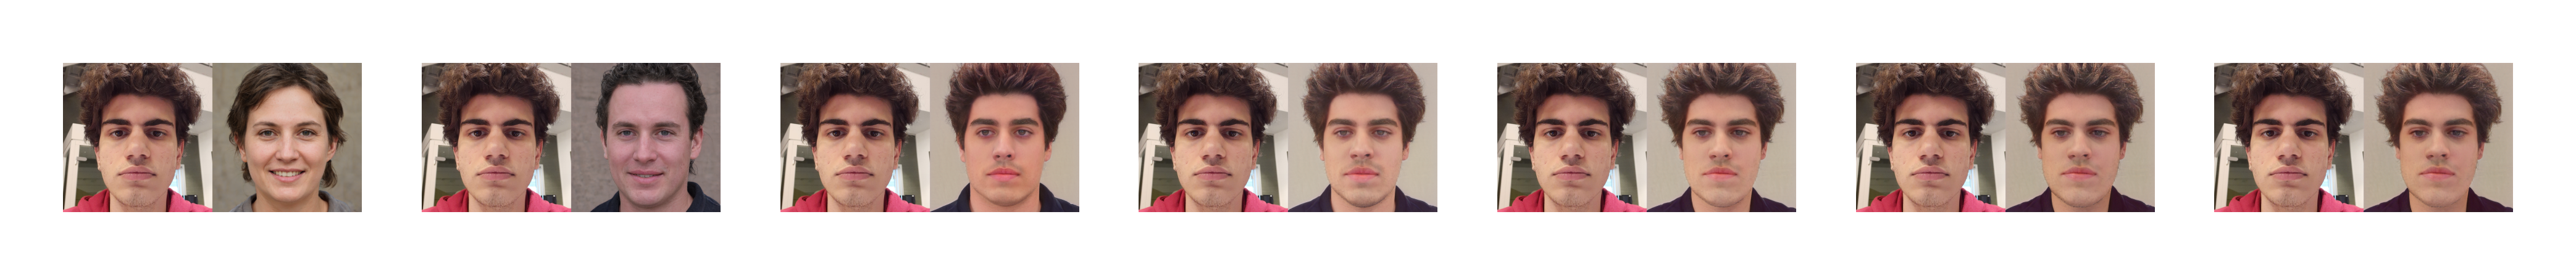

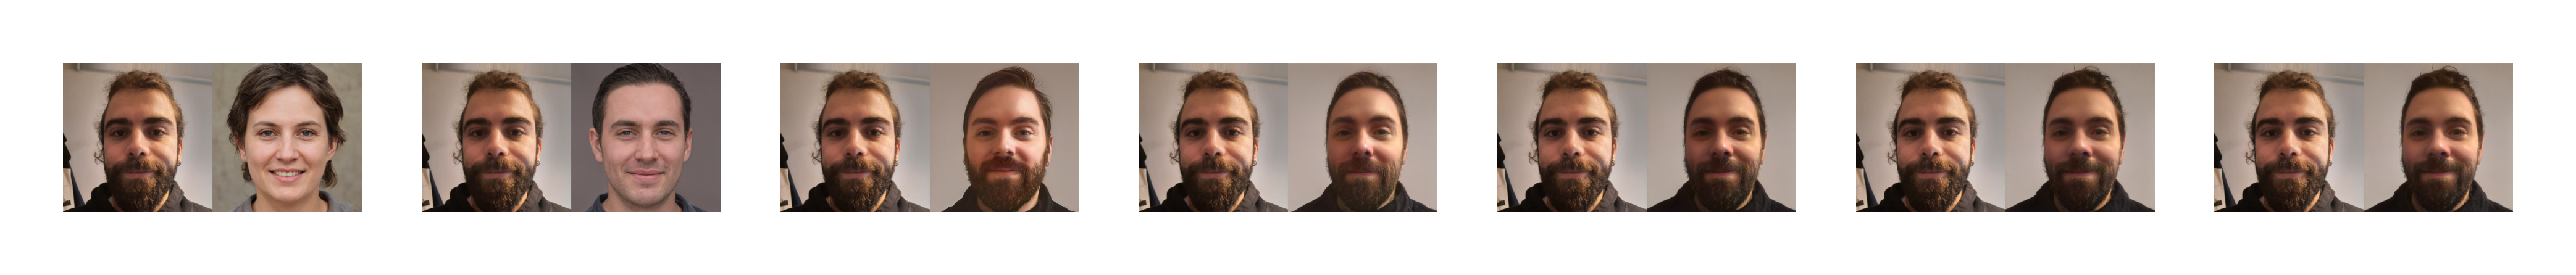

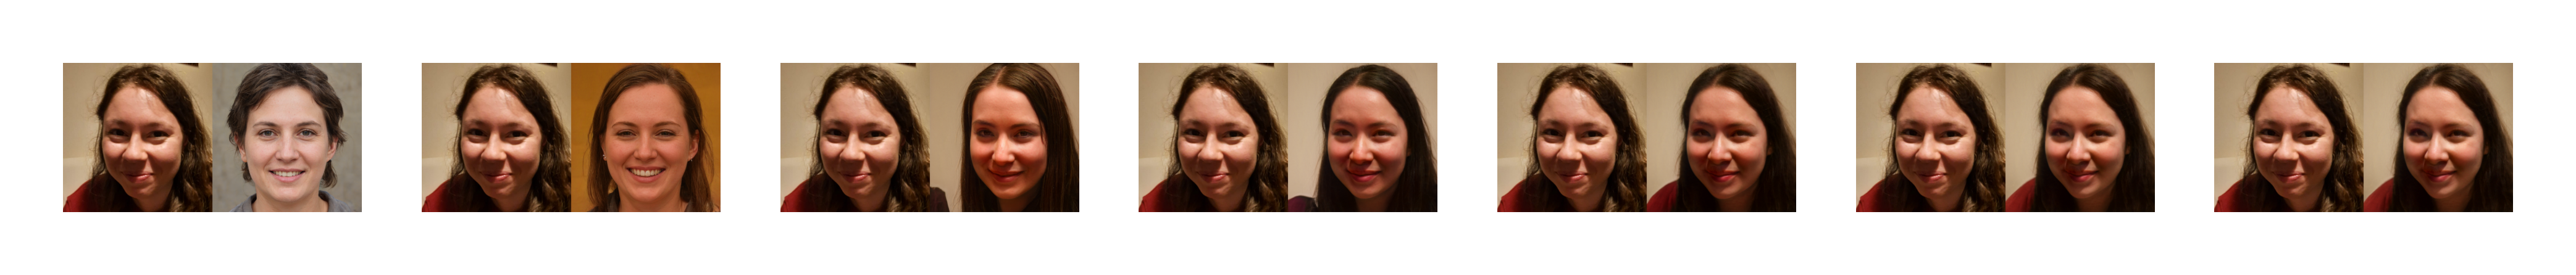

In [ ]:

#aligned_paths = return_image_files(aligned_data_path)
#for i in aligned_paths:
#  run_projection(network_pkl=network,save_video=False,num_steps=300,num_blocks=5,save_graph=True,seed=209,target_fname=i,outdir=proj_out_path+"/"+i.split("/")[1].split(".")[0])


for path in glob.glob(f'{proj_out_path}/*/'):
  return_images(path+"/*.png",5)

#run_projection(network_pkl=network,save_video=False,num_steps=300,num_blocks=5,save_graph=True,seed=209,target_fname="cropped_img.png",outdir="out")

In [ ]:
##################################### STYLE MIX

In [ ]:

from typing import List
from PIL import ImageDraw

def num_range(s: str) -> List[int]:
    '''Accept either a comma separated list of numbers 'a,b,c' or a range 'a-c' and return as a list of ints.'''

    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]



def generate_style_mix(
    network_pkl: str,
    row_paths: List[str],
    col_seeds: List[int],
    col_styles: List[int],
    truncation_psi: float,
    noise_mode: str,
    outdir: str,
    outfile: str
):
    """Generate images using pretrained network pickle.

    Examples:

    \b
    python style_mixing.py --outdir=out --rows=85,100,75,458,1500 --cols=55,821,1789,293 \\
        --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl
    """
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

    os.makedirs(outdir, exist_ok=True)

    max_el = max(col_seeds)
    row_seeds = []
    for i in range(len(row_paths)):
      row_seeds.append(max_el+i+1)

    print('Generating W vectors...')
    all_seeds = list(set(row_seeds + col_seeds))

    all_z = np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in all_seeds])
    print(all_z.shape)
    
    row_ws=[]
    for i in range(len(row_paths)):
      row_ws.append(np.load(row_paths[i])['w'])
    
    row_ws= torch.from_numpy(np.asarray(row_ws)).to(device)
    



    all_w = G.mapping(torch.from_numpy(all_z).to(device), None)
    for i in range(len(row_paths)):
      all_w[(-i-1)]=row_ws[i]

    w_avg = G.mapping.w_avg
    all_w = w_avg + (all_w - w_avg) * truncation_psi
    w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))}

    
    

    print('Generating images...')
    all_images = G.synthesis(all_w, noise_mode=noise_mode)
    all_images = (all_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
    image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

    print('Generating style-mixed images...')
    for row_seed in row_seeds:
        for col_seed in col_seeds:
            w = w_dict[row_seed].clone()
            w[col_styles] = w_dict[col_seed][col_styles]
            image = G.synthesis(w[np.newaxis], noise_mode=noise_mode)
            image = (image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
            image_dict[(row_seed, col_seed)] = image[0].cpu().numpy()

    print('Saving images...')
    os.makedirs(outdir, exist_ok=True)
    #for (row_seed, col_seed), image in image_dict.items():
    #    PIL.Image.fromarray(image, 'RGB').save(f'{outdir}/{row_seed}-{col_seed}.png')

    print('Saving image grid...')
    W = G.img_resolution
    H = G.img_resolution
    canvas = PIL.Image.new('RGB', (W * (len(col_seeds) + 1), H * (len(row_seeds) + 1)), 'black')
    for row_idx, row_seed in enumerate([0] + row_seeds):
        for col_idx, col_seed in enumerate([0] + col_seeds):
            if row_idx == 0 and col_idx == 0:
                continue
            key = (row_seed, col_seed)
            if row_idx == 0:
                key = (col_seed, col_seed)
            if col_idx == 0:
                key = (row_seed, row_seed)
            canvas.paste(PIL.Image.fromarray(image_dict[key], 'RGB'), (W * col_idx, H * row_idx))
    canvas.save(f'{outdir}/{outfile}.png')




In [ ]:
projected_w_paths=[]

for path in glob.glob(f'{proj_out_path}/*/'):
  for proj in glob.glob(path+"/*.npz"):
    projected_w_paths.append(proj)
print(projected_w_paths)
    
#generate_style_mix(network_pkl = network, row_seeds=projected_w_paths,col_seeds=[900,923,416,906], col_styles=[i for i in range(4,9)],truncation_psi=1,noise_mode="const",outdir="style_out")

['projection_out/cropped_img2/projected_wcropped_img2.npz', 'projection_out/cropped_img1/projected_wcropped_img1.npz', 'projection_out/cropped_img3/projected_wcropped_img3.npz']


In [ ]:


#0-4 coarse
#4-12 medium
#12-18 fine


tags = ["coarse","medium","fine"]

ranges = [[0,4],[4,12],[12,18]]


c = zip(tags,ranges)
print(c)


#generate_style_mix(network_pkl = network, row_paths=projected_w_paths,col_seeds=[900,923,416,906], col_styles=[i for i in range(0,6)],truncation_psi=1,noise_mode="const",outdir="style_out",outfile="bla")

